In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper

In [3]:
#Reading the file, BP filtering
local_path= '/home/mmp/Documents/Trace_20230929_12_12_03_29sep_rec2.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)



#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=6000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=180*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")

Sampling frequency: 20000.0
Number of channels: 1012
Number of segments: 1
total_recording: 181.06 s
chunk duration: 180.0 s


In [4]:
default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)
default_KS2_params['keep_good_only'] = True
# default_KS2_params['detect_threshold'] = 12
# default_KS2_params['projection_threshold']=[18, 10]
# default_KS2_params['preclust_threshold'] = 8
run_sorter = ss.run_kilosort2(recording_chunk, output_folder="./sorting/KS_organoid_trace", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True}


/tmp/ipykernel_538420/1064362900.py:7: DeprecationWarning: run_kilosort2 is deprecated. Use run_sorter(sorter_name='kilosort2') instead.
  run_sorter = ss.run_kilosort2(recording_chunk, output_folder="./sorting/KS_organoid_trace", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)


Starting container
Installing spikeinterface==0.98.2 in kilosort2-maxwellcomplib:latest
Installing extra requirements: ['neo', 'h5py']
Running kilosort2 sorter inside kilosort2-maxwellcomplib:latest
Stopping container


In [5]:
sorting_KS3 = ss.Kilosort2Sorter._get_result_from_folder('./sorting/KS_organoid_trace/sorter_output/')
total_units = sorting_KS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
sorting_good = sorting_KS3.remove_empty_units()
sorting_good = spikeinterface.curation.remove_excess_spikes(sorting_good,recording_chunk)
job_kwargs = dict(n_jobs=4, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sorting_good,folder='./sorting/waveforms_organoid_trace/',overwrite=True,**job_kwargs)
print(waveforms)

41


extract waveforms memmap:   0%|          | 0/180 [00:00<?, ?it/s]

WaveformExtractor: 1012 channels - 41 units - 1 segments
  before:60 after:80 n_per_units:500


In [6]:
waveforms = si.load_waveforms('./sorting/waveforms_organoid_trace/',sorting_good)
print(waveforms)
job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)

WaveformExtractor: 1012 channels - 41 units - 1 segments
  before:60 after:80 n_per_units:500


extract amplitudes:   0%|          | 0/180 [00:00<?, ?it/s]

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:590: UserWarning: Units [1, 10, 12, 32, 33, 34, 46, 55, 70, 94, 96, 106, 110, 115, 120, 121, 181, 185, 196, 203, 213, 220, 227, 228, 229, 232, 234, 242] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")


In [7]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms, peak_sign='neg')
print(extremum_channels_ids)

{1: '4', 4: '37', 10: '185', 12: '757', 17: '58', 25: '97', 31: '166', 32: '208', 33: '143', 34: '224', 46: '224', 54: '249', 55: '249', 56: '249', 62: '262', 69: '309', 70: '309', 72: '328', 94: '463', 96: '482', 106: '525', 110: '545', 115: '561', 120: '605', 121: '605', 153: '639', 181: '605', 185: '723', 196: '752', 202: '799', 203: '807', 211: '831', 213: '847', 220: '895', 223: '691', 227: '909', 228: '916', 229: '926', 232: '968', 234: '240', 242: '863'}


[97]


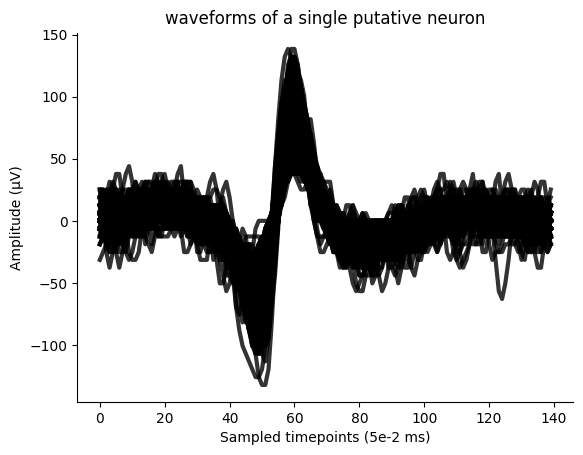

In [9]:

fig, ax = plt.subplots()
for i, unit_id in enumerate([25]):
    
    wf = waveforms.get_waveforms(unit_id)
    
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(number)
    ax.plot(wf[:,:, number[0]].T,  lw=3, color='black', alpha=0.8, linestyle='-', marker='', markersize=0)
    ax.set_title(f"waveforms of a single putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

# Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
  
plt.savefig('/home/mmp/Documents/Images_25sep/waveforms_organoid.pdf',format='pdf')

(140, 1012)
[97]


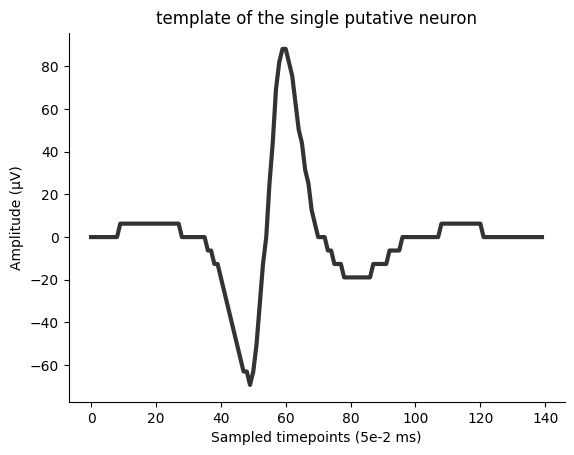

In [11]:

fig, ax = plt.subplots()
for i, unit_id in enumerate([25]):
    
    template = waveforms.get_template(unit_id,mode='median')
    print(template.shape)
    #print(int(extremum_channels[unit_id]))
    number = waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])
    print(number)
    ax.plot(template[:, number[0]].T, lw=3, color='black', alpha=0.8, linestyle='-', marker='', markersize=0)
    ax.set_title(f"template of the single putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

# Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
#FFD700
    plt.savefig('/home/mmp/Documents/Images_25sep/template_organoid.pdf',format='pdf')
    plt.show()